# Next Word Prediction w/ LSTM - [BSD Corpus](https://github.com/tsuruoka-lab/BSD) (English only)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1jihTIp3NQy58nkHPc6gf0yYIpW24KPxd?usp=sharing)

## Data preparation

In [1]:
## 1.

import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop

In [2]:
## 2.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## 3.

# Import the data set, and get all sentences
import pandas as pd

df = pd.read_json('https://raw.githubusercontent.com/tsuruoka-lab/BSD/master/train.json')
print(df['tag'].unique())

['phone call' 'meeting' 'face-to-face conversation' 'general chatting'
 'presentation' 'training']


In [5]:
## 4.

df

,id,tag,title,original_language,conversation
0,190329_J07_03,phone call,伝言への折り返し電話 打ち合わせ日程調整,ja,"[{'no': 1, 'ja_speaker': '土井さん', 'en_speaker':..."
1,190329_J06_11,meeting,株主総会に関する役員向け説明（２）,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
2,190329_J06_10,meeting,株主総会に関する役員向け説明（１）,ja,"[{'no': 1, 'ja_speaker': '友井さん', 'en_speaker':..."
3,190329_J06_09,face-to-face conversation,信託銀行から株主名簿を受領,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
4,190329_J06_08,face-to-face conversation,株主総会への臨場要請,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
...,...,...,...,...,...
665,190315_E001_05,presentation,Presentation: Company introduction,en,"[{'no': 1, 'en_speaker': 'Mr. Asano Yuki', 'ja..."
666,190315_E001_04,training,Training: training a new employee,en,"[{'no': 1, 'en_speaker': 'Mr. Ben Sherman', 'j..."
667,190315_E001_03,general chatting,General chatting: Company Christmas party,en,"[{'no': 1, 'en_speaker': 'Ms. Amy Lin', 'ja_sp..."
668,190315_E001_02,phone call,Phone call: requesting a lunch meeting.,en,"[{'no': 1, 'en_speaker': 'Mr. John Smith', 'ja..."


In [6]:
## 5.

df_convs = pd.concat([pd.json_normalize(df['conversation'][i]) for i in range(len(df))],ignore_index=True)
trainen = df_convs["en_sentence"].values.tolist()
trainja = df_convs["ja_sentence"].values.tolist()

In [7]:
## 6.

df_convs

,no,ja_speaker,en_speaker,ja_sentence,en_sentence
0,1,土井さん,Doi-san,はい、K社システム開発部です。,Hi this is the systems development department ...
1,2,高市さん,Takaichi-san,H社の高市と申します。,My name is Takaichi from Company H.
2,3,高市さん,Takaichi-san,いつもお世話になっております。,Thank you as always.
3,4,土井さん,Doi-san,こちらこそ、お世話になっております。,Thank you as always as well.
4,5,高市さん,Takaichi-san,稲田さんはいらっしゃいますか？,Is Inada-san there?
...,...,...,...,...,...
19995,28,ボブ クックさん,Mr. Bob Cook,今日の5時までに書き上げます。,I'll finish it by 5 o'clock today.
19996,29,アル ジョンソンさん,Mr. Al Johnson,完璧だね。,Perfect.
19997,30,アル ジョンソンさん,Mr. Al Johnson,明日ゼネラルマネージャーにA社の件を話しておきますね。,I'll go talk to the general manager tomorrow t...
19998,31,アル ジョンソンさん,Mr. Al Johnson,彼がA社を気に入ってくれて、投資できる方向に決まることを願いましょう。,Hopefully he will like Company A and make the ...


In [8]:
## 7.

len(trainen)

20000

In [9]:
## 8.

trainen[140:160]

['I hope so.',
 'Okay, anyways, we will send 2 police officers from our side to the general meeting of shareholders on the day.',
 'Thank you very much.',
 'I will have them speak to your reception around 9:30 in the morning.',
 'Okay.',
 'I will be stationed at the reception ten minutes before the start of the general meeting so please let me know.',
 'Okay, got it.',
 'Alright, then I look forward to working with you on the day.',
 'Thank you for calling, this is the Judicial Scrivener office T.',
 'Thank you as always, my name is Takada from Company I.',
 'Thank you.',
 'Sorry but is Mr. Takanashi in today?',
 'Please wait a moment.',
 'Thank you for holding, this is Takanashi.',
 'Thank you as always, this is Takada.',
 "I'm calling today in regards to a registration request.",
 'I exercised the stock option last month and the stock increased.',
 "And I'd like to ask you to do the registration process for changing the total number of stock issued.",
 'Okay.',
 'I will send you an e

In [10]:
## 9.

#concat all english messages
text = ' '.join(trainen[0:10000]) # Out of RAM if we use all the data
print('length of the corpus is: :', len(text))

length of the corpus is: : 532978


In [11]:
## 10.

# tokenizer
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [12]:
## 11.

# get unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [13]:
## 12.

len(unique_words)

6197

In [14]:
## 13.

unique_words[1000:1020]

array(['Shanghai', 'She', 'Shibata', 'Shibuya', 'Shiota', 'Shiraishi',
       'Shiroki', 'Shirota', 'Shizuo', 'Shodoshima', 'Shop', 'Should',
       'Shouldn', 'Shuji', 'Silence', 'Silicone', 'Similar', 'Since',
       'Sir', 'Six'], dtype='<U16')

## Feature Engineering
- Prepare the model input (x) and output (y)
- Prepare word2id and id2word dictionaries

In [15]:
## 14.

# model input = prev_words
# model output = next_words

WORD_LENGTH = 5
next_words = []
prev_words = []
for j in range(len(words) - WORD_LENGTH):
     prev_words.append(words[j:j + WORD_LENGTH])
     next_words.append(words[j + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['Hi', 'this', 'is', 'the', 'systems']
development


In [16]:
## 15.

# convert features into numpy arrays
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
# prepare word2id index
for i, each_words in enumerate(prev_words):
   for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
   Y[i, unique_word_index[next_words[i]]] = 1
word2id = unique_word_index

In [17]:
## 16.

# prepare id2word index ==> for inference
id2word = {y:x for x,y in unique_word_index.items()}

## Training

In [18]:
## 17.

# build model
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [19]:
## 18.

# train model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
769/769 [==============================] - 126s 161ms/step - loss: 5.8386 - accuracy: 0.1254 - val_loss: 5.6074 - val_accuracy: 0.1687
Epoch 2/2
769/769 [==============================] - 127s 165ms/step - loss: 5.4430 - accuracy: 0.1790 - val_loss: 5.9375 - val_accuracy: 0.1756


In [20]:
## 19.

# save model
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [21]:
## 20.

history

{'loss': [5.838614463806152, 5.443006992340088],
 'accuracy': [0.1253737360239029, 0.17895860970020294],
 'val_loss': [5.60744047164917, 5.937475681304932],
 'val_accuracy': [0.16866305470466614, 0.1756182312965393]}

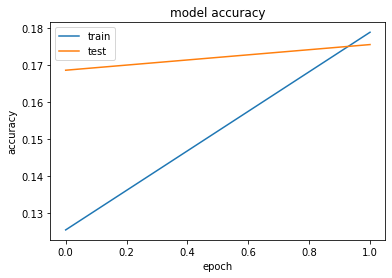

In [22]:
## 21.

# evaluate model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

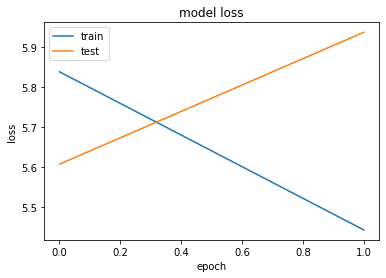

In [23]:
## 22.

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Load Trained Model

In [ ]:
## 23.

# load model -- 32.3 m
### model = load_model('/content/drive/MyDrive/Colab Notebooks/nwp-en-bsd/next_word_model.h5')

## Will NOT run this time for the purposes of the checkpoint

## Predict next words

In [24]:
## 24.

def prepare_input(text):
    words = tokenizer.tokenize(text)
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(words):
        x[0, t, word2id[word]] = 1.
        
    return x

In [27]:
## 25.

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [28]:
## 26.

def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_word = id2word[next_index]
        text = text[1:] + next_word
        completion += next_word
        
        if len(original_text + completion) + 2 > len(original_text) and next_word == ' ':
            return completion

In [29]:
## 27.

def predict_next_word(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [id2word[idx] for idx in next_indices]

### Example #1

Starting sentence: "I look forward to working"

In [30]:
## 28.

# current model only accept input with 5 words
input="I look forward to working"
print(predict_next_word(input, 5))

# predicted sentence: "I look forward to working with" 

['with', 'on', 'in', 'to', 'about']


In [31]:
## 29.

input="look forward to working with"
print(predict_next_word(input, 5))

# predicted sentence: "I look forward to working with you" 

['you', 'the', 'that', 'it', 'this']


In [32]:
## 30.

input="forward to working with you"
print(predict_next_word(input, 5))

# predicted sentence: "I look forward to working with you about" 

['I', 'about', 'Yes', 'Okay', 'Thank']


In [33]:
## 31.

input="to working with you about"
print(predict_next_word(input, 5))

# predicted sentence: "I look forward to working with you about the" 

['the', 'it', 'this', 'you', 'that']


In [34]:
## 32.

input="working with you about the"
print(predict_next_word(input, 5))

# predicted sentence: "I look forward to working with you about the new"

['new', 'meeting', 'company', 'office', 'other']


### Example #2

Starting sentence: "Good morning I would like"

In [35]:
## 33.

# current model only accept input with 5 words
input="Good morning I would like"
print(predict_next_word(input, 5))

# predicted sentence: "Good morning I would like to" 

['to', 'you', 'it', 'the', 'a']


In [36]:
## 34.

input="morning I would like to"
print(predict_next_word(input, 5))

# predicted sentence: "Good morning I would like to be" 

['be', 'do', 'have', 'ask', 'go']


In [37]:
## 35.

input="I would like to be"
print(predict_next_word(input, 5))

# predicted sentence: "Good morning I would like to be the" 

['the', 'a', 'able', 'in', 'more']


In [38]:
## 36.

input="would like to be the"
print(predict_next_word(input, 5))

# predicted sentence: "Good morning I would like to be same" 

['new', 'company', 'the', 'same', 'time']


In [39]:
## 37.

input="like to be the same"
print(predict_next_word(input, 5))

# predicted sentence: "Good morning I would like to be same as" 

['time', 'as', 'for', 'I', 'to']
